<a href="https://colab.research.google.com/github/RadimKozl/OpenCV_academy_my_work/blob/main/Keras_finetune_sports_EfficientNetB0_kaggle_CZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/RadimKozl/OpenCV_academy_my_work/blob/img/OpenCV_logo.png?raw=1" alt="OpenCV logo" style="width: 200px;"/>

###### <font size="10">Lekce 22 - Jemné doladění klasifikátoru obrázků pomocí Google Colab</font>




## ***Transfer Learning a Jemné doladění (Fine-tuning)***

# ***Úvod***

## Obsah lekce

V této kapitole se naučíme, jak doladit předem natrénovaný model pro jiný úkol, než pro který byl původně natrénován.

Když trénujeme síť od začátku, narazíme na následující dvě omezení:

- ***Potřeba obrovského množství dat*** – Vzhledem k tomu, že síť má miliony parametrů, abychom získali optimální sadu parametrů, potřebujeme mít hodně dat.
- ***Potřeba obrovského výpočetní výkonu*** – I když máme hodně dat, školení obecně vyžaduje více iterací a vybírá si daň z výpočetních zdrojů.

Předtrénované modely jsou trénovány na problémech klasifikace obrázků ve velkém měřítku. Konvoluční vrstvy fungují jako extraktor prvků a plně spojené vrstvy fungují jako klasifikátory.

Vzhledem k tomu, že tyto modely jsou velmi velké a viděly obrovské množství obrázků, mají tendenci učit se velmi dobře, rozlišují vlastnosti. Můžeme buď použít konvoluční vrstvy pouze jako extraktor prvků a změnit poslední vrstvu podle našeho problému, nebo můžeme upravit již natrénované konvoluční vrstvy tak, aby vyhovovaly našemu problému. První přístup je známý jako ***Transfer Learning*** a druhý jako ***Fine-tuning***.

Úkolem doladění sítě je vyladit parametry již natrénované sítě tak, aby se přizpůsobila novému úkolu. Počáteční vrstvy sítě se učí velmi obecné rysy a jak postupujeme výše v síti, vrstvy mají tendenci učit se vzory specifičtější pro úkol, na který jsou trénovány. Pro doladění tedy chceme zachovat původní vrstvy nedotčené (nebo je zmrazit) a přeškolit pozdější vrstvy pro náš úkol.

Jemné doladění se tak vyhne oběma výše uvedeným omezením.

- Za prvé, netrénujeme celou síť. Za druhé, část, která je trénována, není trénována od nuly.
- Vzhledem k tomu, že parametrů, které je třeba aktualizovat, je méně, budeme také potřebovat kratší čas.

Zpravidla platí, že když máme malou tréninkovou sadu a náš problém je podobný úkolu, na který byly trénované předem trénované modely, můžeme použít přenosové učení (transfer learning). Pokud máme dostatek dat, můžeme se pokusit vyladit konvoluční vrstvy tak, aby se naučily robustnější funkce relevantní pro náš problém. [Zde](https://cs231n.github.io/transfer-learning/) můžete získat podrobný přehled o Fine-tuning a transfer learningu.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os,shutil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [ ]:
# Install kaggle
!pip install kaggle


# ***Načtení datové sady z kaggle***

Jak načíst datové sady kaggle jsme již probrali v předchozí části. Budeme používat datovou sadu Sport odvozenou od kaggle datoveé sady [100 Sports Image Classification](https://www.kaggle.com/datasets/gpiosenka/sports-classification). Datová sada obsahuje 100 tříd sportů, je rozdělena do jednotlivých sad dat, ty jsme sloučili do jedné.

>POZNÁMKA: Ke stažení datové sady kaggle na colab budete muset použít svůj token API z kaggle ( soubor kaggle.json ). Pro provedení experimentu můžete datovou sadu také ručně nahrát na disk Google.

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d radimkzl/sports

# Unzip all files and suppress output
!unzip -q sports.zip

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
Dataset URL: https://www.kaggle.com/datasets/radimkzl/sports
License(s): unknown
 97% 349M/358M [00:07<00:00, 31.1MB/s]
100% 358M/358M [00:07<00:00, 52.1MB/s]


In [ ]:
# !cat ~/.kaggle/kaggle.json

In [ ]:
# This folder contians all the class folders
main_path = 'Sports/'
print(main_path)

Sports/


In [ ]:
# all class names
classnames = os.listdir(main_path)
print(classnames)

['uneven bars', 'weightlifting', 'sidecar racing', 'sailboat racing', 'horseshoe pitching', 'jai alai', 'javelin', 'snow boarding', 'figure skating men', 'croquet', 'frisbee', 'balance beam', 'cricket', 'bungee jumping', 'disc golf', 'ice climbing', 'basketball', 'shuffleboard', 'water polo', 'rock climbing', 'shot put', 'horse racing', 'bowling', 'ice yachting', 'bobsled', 'hockey', 'curling', 'olympic wrestling', 'figure skating women', 'rollerblade racing', 'steer wrestling', 'parallel bar', 'fly fishing', 'harness racing', 'baton twirling', 'gaga', 'skydiving', 'field hockey', 'water cycling', 'lacrosse', 'hurdles', 'arm wrestling', 'formula 1 racing', 'swimming', 'archery', 'motorcycle racing', 'judo', 'billiards', 'pole vault', 'baseball', 'roller derby', 'sky surfing', 'football', 'giant slalom', 'sumo wrestling', 'golf', 'luge', 'rings', 'air hockey', 'hydroplane racing', 'rugby', 'hang gliding', 'ampute football', 'horse jumping', 'trapeze', 'boxing', 'pole dancing', 'chuckwag

In [ ]:
# See how many images you have per class, this helps you set the required percentage of validation data.
for each_class in classnames:
  print("Class: {}, has {} samples".format( each_class,len(os.listdir(os.path.join(main_path,each_class )))))

Class: uneven bars, has 166 samples
Class: weightlifting, has 144 samples
Class: sidecar racing, has 143 samples
Class: sailboat racing, has 154 samples
Class: horseshoe pitching, has 112 samples
Class: jai alai, has 142 samples
Class: javelin, has 146 samples
Class: snow boarding, has 127 samples
Class: figure skating men, has 138 samples
Class: croquet, has 144 samples
Class: frisbee, has 141 samples
Class: balance beam, has 157 samples
Class: cricket, has 139 samples
Class: bungee jumping, has 135 samples
Class: disc golf, has 133 samples
Class: ice climbing, has 140 samples
Class: basketball, has 179 samples
Class: shuffleboard, has 140 samples
Class: water polo, has 140 samples
Class: rock climbing, has 151 samples
Class: shot put, has 159 samples
Class: horse racing, has 149 samples
Class: bowling, has 130 samples
Class: ice yachting, has 122 samples
Class: bobsled, has 148 samples
Class: hockey, has 182 samples
Class: curling, has 151 samples
Class: olympic wrestling, has 177 sa

# ***Uspořádejme si data***

Již jsme si vysvětlili v předchozí části, jak by měla být data uspořádána, aby byla předána do tréninkového kanálu v Kerasu.

Zde budeme data úhledně umístit do složek *train* a *validation* uvnitř hlavní složky s názvem 'fruits' (změňte název, pokud chcete), můžete nastavit procento sady *validation*. Nastavili jsme to na 15 %. Takže 15 % obrázků z každé třídy půjde do složky *validation* a zbytek do složky *train*.

In [ ]:
#!rm -r sports

base_dir= 'sports'

total_train_images = 0
total_val_images = 0

if os.path.exists(base_dir) == False:
    os.mkdir(base_dir)

    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)

    validation_dir = os.path.join(base_dir, 'validation')
    os.mkdir(validation_dir)

    # Set the percent of validation data you want.
    validation_percent = 15

    for each_class in classnames:

      source_directory = os.path.join(main_path,each_class )
      destination_train_directory = os.path.join(train_dir,each_class)
      destination_validation_directory = os.path.join(validation_dir,each_class)


      total_image_count = len(os.listdir(source_directory))

      valid_image_count = int(np.floor(total_image_count * (validation_percent/100)))

      train_images_count = int( total_image_count - valid_image_count )

      total_train_images +=  train_images_count
      total_val_images += valid_image_count

      os.mkdir(destination_train_directory)
      os.mkdir(destination_validation_directory)

      # copying the data to class's train folder
      file_names = os.listdir(source_directory)[:train_images_count]

      for fname in file_names:
          src = os.path.join(source_directory, fname)
          dst = os.path.join(destination_train_directory, fname)
          shutil.copyfile(src, dst)


      # Copying the data to class's validation folder
      file_names = os.listdir(source_directory)[train_images_count:]

      for fname in file_names:
          src = os.path.join(source_directory, fname)
          dst = os.path.join(destination_validation_directory, fname)
          shutil.copyfile(src, dst)

      print('total training {} images: {}'.format(each_class, len(os.listdir(destination_train_directory))))
      print('total validation {} images: {}'.format(each_class, len(os.listdir(destination_validation_directory))))

    else:
        train_dir = os.path.join(base_dir, 'train')
        validation_dir = os.path.join(base_dir, 'validation')

total training uneven bars images: 142
total validation uneven bars images: 24
total training weightlifting images: 123
total validation weightlifting images: 21
total training sidecar racing images: 122
total validation sidecar racing images: 21
total training sailboat racing images: 131
total validation sailboat racing images: 23
total training horseshoe pitching images: 96
total validation horseshoe pitching images: 16
total training jai alai images: 121
total validation jai alai images: 21
total training javelin images: 125
total validation javelin images: 21
total training snow boarding images: 108
total validation snow boarding images: 19
total training figure skating men images: 118
total validation figure skating men images: 20
total training croquet images: 123
total validation croquet images: 21
total training frisbee images: 120
total validation frisbee images: 21
total training balance beam images: 134
total validation balance beam images: 23
total training cricket images: 

# ***Zmrazte požadované vrstvy***

V Keras má každá vrstva parametr nazvaný ***“trainable”***. Pro zmrazení vah konkrétní vrstvy bychom měli nastavit tento parametr na ***False***, což znamená, že tato vrstva by neměla být trénována. A je to! Procházíme každou vrstvu a vybíráme, které vrstvy chceme trénovat.

```python
# Freeze the layers except the last 4 layers
for layer in EfficientNetB0_conv.layers[:-4]:
    layer.trainable = False
```

# ***Experiment 1: Zmrazení všech vrstev – Stejné jako Transfer Learning***

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, mobilenet

image_size = 224

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
#Load the VGG model
EfficientNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
#include_topはFully Connected Layerはロードしないという意味

# Freeze all the layers
for layer in EfficientNetB0_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in EfficientNetB0_conv.layers:
    print(layer, layer.trainable)



# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB0_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.src.engine.input_layer.InputLayer object at 0x7d33604bef20> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d33604bd6f0> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7d3368167c70> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d3373c51330> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d33604bce50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d33f7c87310> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d33680c0a90> False
<keras.src.layers.core.activation.Activation object at 0x7d33f7c878b0> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7d33680c1c60> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d336808ab00> False
<keras.src.layers.core.activation.Activation object at 0x7d33680c2950> False
<keras.src.layers.pooli

## ***Nastavte generátory dat***

Data jsme již rozdělili na trénovací a validační a uchovávali je ve složkách *„train“* a *„validation“*. Můžeme použít ***ImageDataGenerator*** dostupný v Kerasu ke čtení obrázků v dávkách přímo z těchto složek a volitelně provádět augmentaci dat. Použijeme dva různé generátory dat pro trénovací a validační složky.

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# No Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 12362 images belonging to 100 classes.
Found 2129 images belonging to 100 classes.


## ***Trénujte model***

Doposud jsme vytvořili model a nastavili data pro trénování. Takže bychom měli pokračovat v tréninku a zkontrolovat výkon modelu. Budeme muset určit *optimalizátor* a *rychlost učení* a začít trénovat pomocí funkce ***model.fit()***. Po skončení tréningu model uložíme.

In [ ]:
%%time
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/20
618/618 [==============================] - 49s 64ms/step - loss: 4.6348 - acc: 0.0126 - val_loss: 4.6045 - val_acc: 0.0141
Epoch 2/20
618/618 [==============================] - 35s 57ms/step - loss: 4.6047 - acc: 0.0137 - val_loss: 4.6039 - val_acc: 0.0141
Epoch 3/20
618/618 [==============================] - 39s 63ms/step - loss: 4.6037 - acc: 0.0126 - val_loss: 4.6032 - val_acc: 0.0141
Epoch 4/20
618/618 [==============================] - 36s 58ms/step - loss: 4.6032 - acc: 0.0129 - val_loss: 4.6027 - val_acc: 0.0141
Epoch 5/20
618/618 [==============================] - 43s 69ms/step - loss: 4.6026 - acc: 0.0138 - val_loss: 4.6021 - val_acc: 0.0141
Epoch 6/20
618/618 [==============================] - 36s 58ms/step - loss: 4.6021 - acc: 0.0130 - val_loss: 4.6016 - val_acc: 0.0136
Epoch 7/20
618/618 [==============================] - 46s 74ms/step - loss: 4.6016 - acc: 0.0123 - val_loss: 4.6012 - val_acc: 0.0141
Epoch 8/20
618/618 [==============================] - 36s 57ms

## ***Uložte model***

Modely Keras jsou uloženy ve formátu ***h5***. Můžete použít pouze metodu uložení spolu s názvem požadovaného souboru.

In [ ]:
# Save the Model
model.save('EfficientNetB0_sports_all_freezed.h5')

In [ ]:
# If you want to download your Model run this, you can also download it from the files tab on the left
from google.colab import files
files.download('EfficientNetB0_sports_all_freezed.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ***Zkontrolujte výkon***

Podívejme se na křivky ztrát a přesnosti.

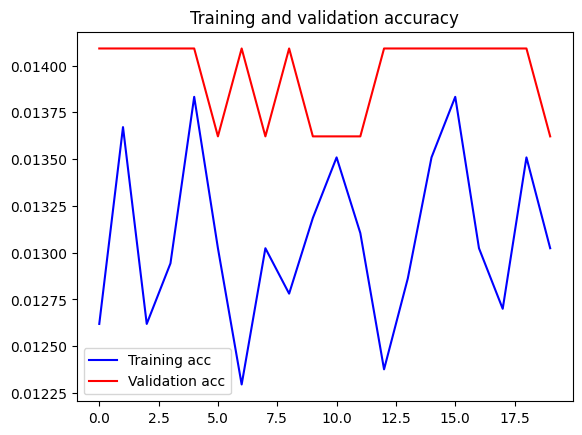

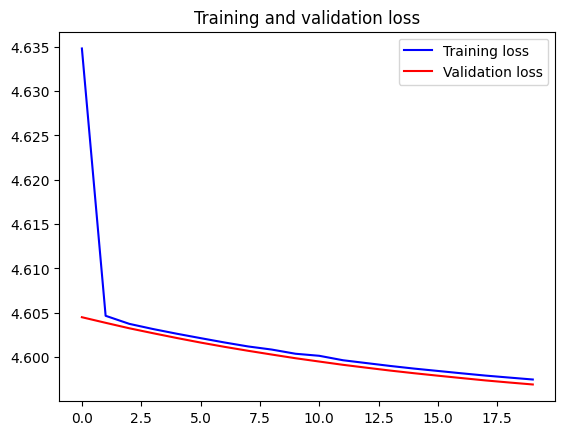

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ***Ukažte chyby***

Také se podívejme vizuálně na chyby, které jsme dostali.

Found 2129 images belonging to 100 classes.
106/106 [==============================] - 6s 43ms/step
No of errors = 2100/2129


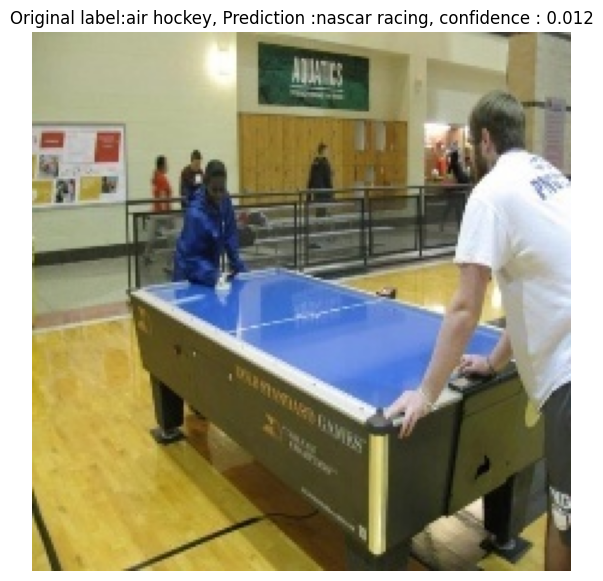

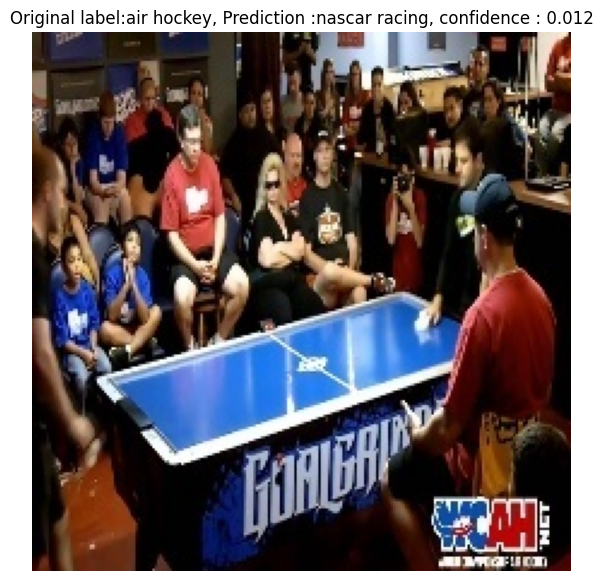

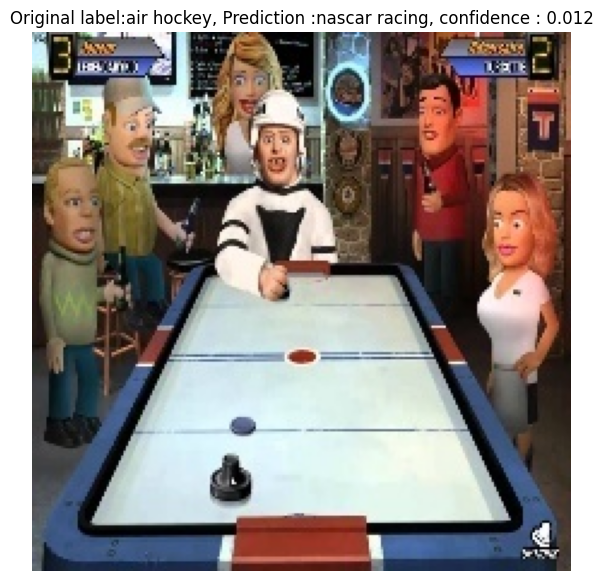

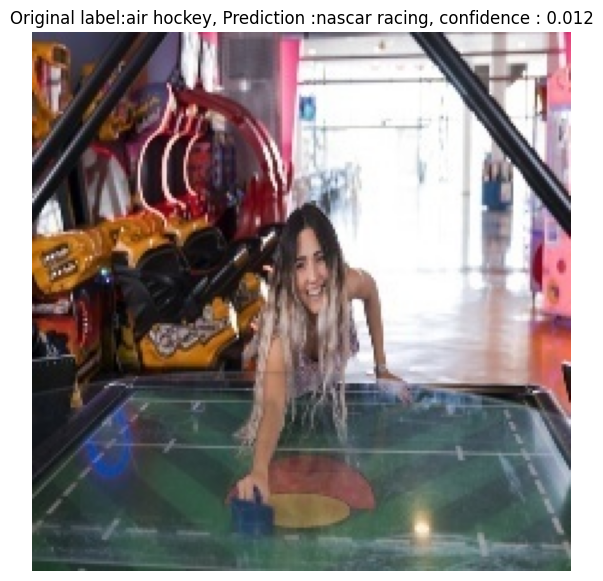

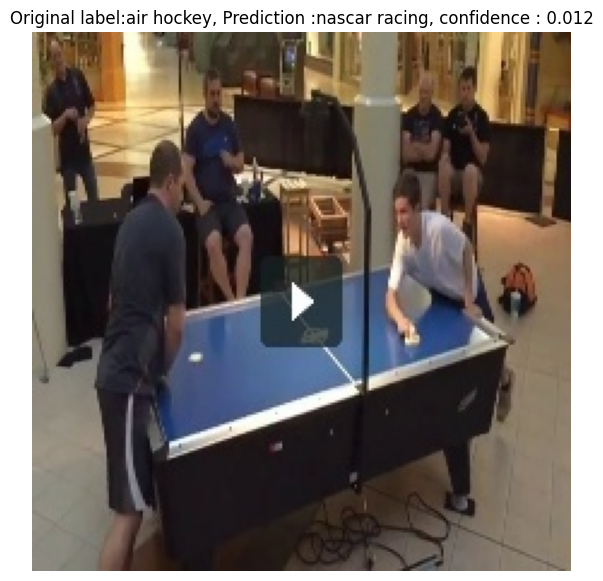

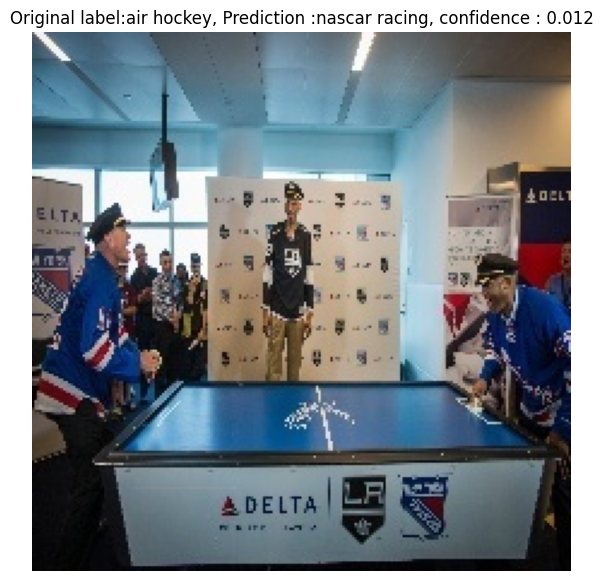

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    if i <= 5:
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

## ***Vyhodnocení***

Vidíme, že ztráta testu nekonverguje, i když tréninková ztráta stále klesá. Zkusme natrénovat další vrstvy (Jemné doladění)

# ***Experiment 2: Trénujte poslední 4 vrstvy bez rozšíření dat***

V tomto experimentu ponecháme počáteční vrstvy zafixované a pouze přetrénujeme poslední 4 vrstvy. Vzhledem k tomu, že počáteční vrstvy se učí obecnější funkce, je dobrým zvykem zmrazit počáteční vrstvy a zároveň doladit poslední vrstvy sítě pro nový úkol.


In [ ]:
#Load the VGG model
EfficientNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all layers except the last 4
for layer in EfficientNetB0_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in EfficientNetB0_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB0_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.src.engine.input_layer.InputLayer object at 0x7d336aadf340> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d336aade0e0> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7d336aad1090> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d336aaf8df0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d32fce72b30> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d32fce72140> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d33682b1ba0> False
<keras.src.layers.core.activation.Activation object at 0x7d33682b2140> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7d33682b2c20> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d33682b1840> False
<keras.src.layers.core.activation.Activation object at 0x7d3368269ba0> False
<keras.src.layers.pooli

## ***Trénujte model***

In [ ]:
# No Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Found 12362 images belonging to 100 classes.
Found 2129 images belonging to 100 classes.
Epoch 1/20
247/247 [==============================] - 46s 149ms/step - loss: 4.6926 - acc: 0.0114 - val_loss: 4.6048 - val_acc: 0.0141
Epoch 2/20
247/247 [==============================] - 33s 134ms/step - loss: 4.6051 - acc: 0.0133 - val_loss: 4.6044 - val_acc: 0.0141
Epoch 3/20
247/247 [==============================] - 36s 144ms/step - loss: 4.6044 - acc: 0.0123 - val_loss: 4.6040 - val_acc: 0.0136
Epoch 4/20
247/247 [==============================] - 34s 139ms/step - loss: 4.6040 - acc: 0.0125 - val_loss: 4.6037 - val_acc: 0.0141
Epoch 5/20
247/247 [==============================] - 32s 129ms/step - loss: 4.6044 - acc: 0.0126 - val_loss: 4.6034 - val_acc: 0.0136
Epoch 6/20
247/247 [==============================] - 34s 135ms/step - loss: 4.6038 - acc: 0.0135 - val_loss: 4.6030 - val_acc: 0.0141
Epoch 7/20
247/247 [==============================] - 33s 132ms/step - loss: 4.6031 - acc: 0.0137 - v

In [ ]:
# Save the Model
model.save('EfficientNetB0_sports_last4_layers.h5')

# you can also download the model to your pc from the files tab on the left

In [ ]:
#from google.colab import files
files.download('EfficientNetB0_sports_last4_layers.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

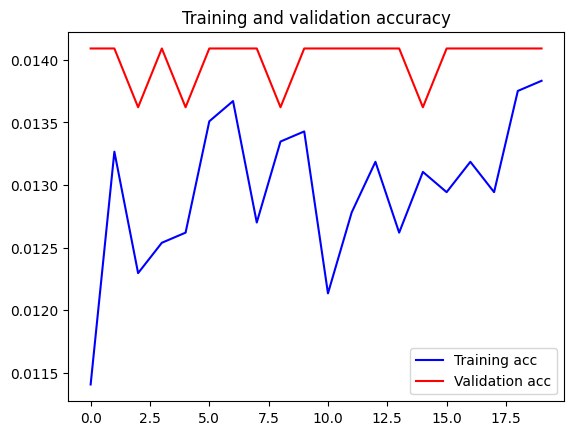

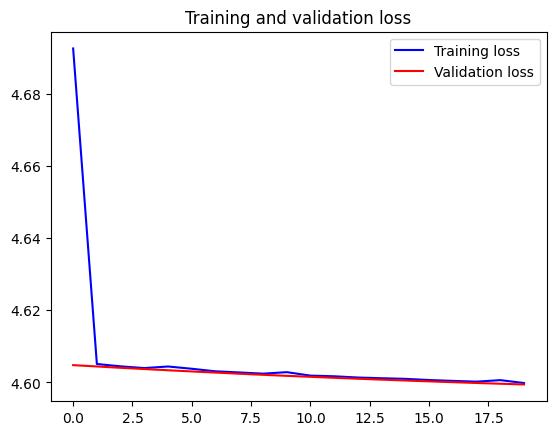

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ***Ukažte chyby***

Found 2129 images belonging to 100 classes.
106/106 [==============================] - 6s 45ms/step
No of errors = 2099/2129


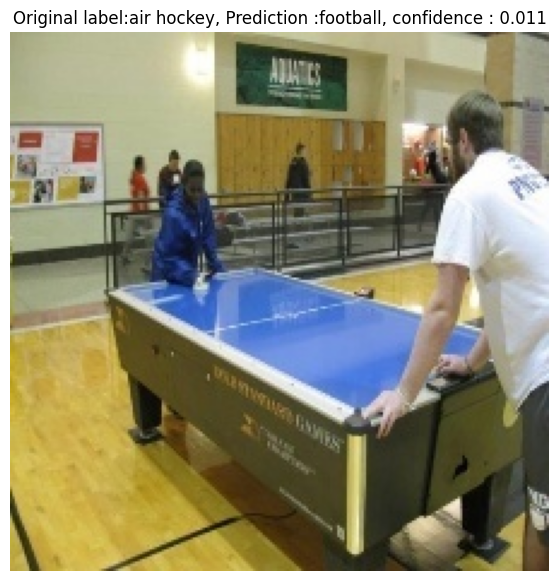

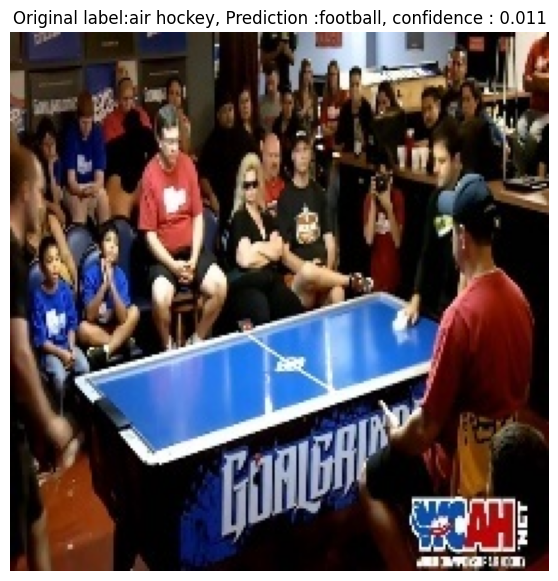

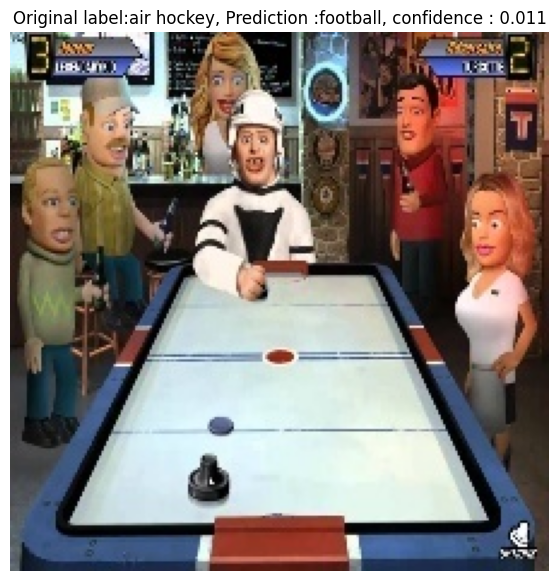

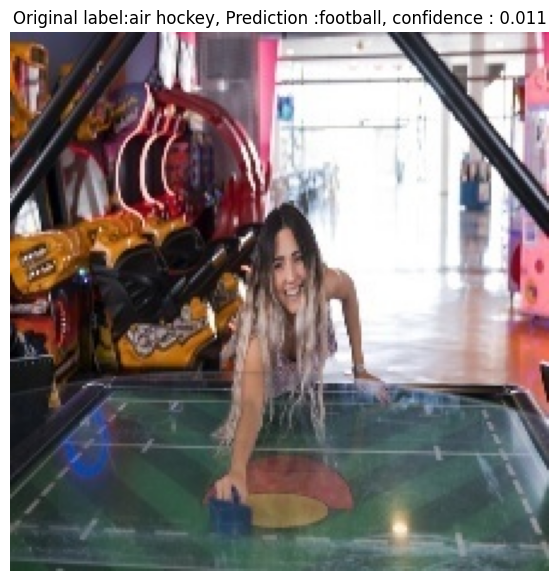

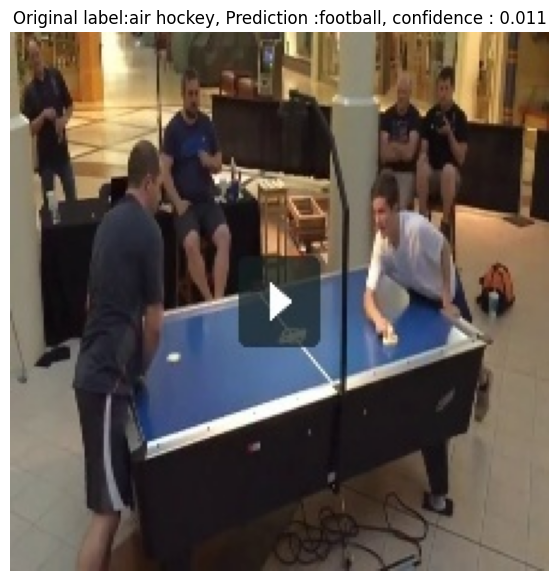

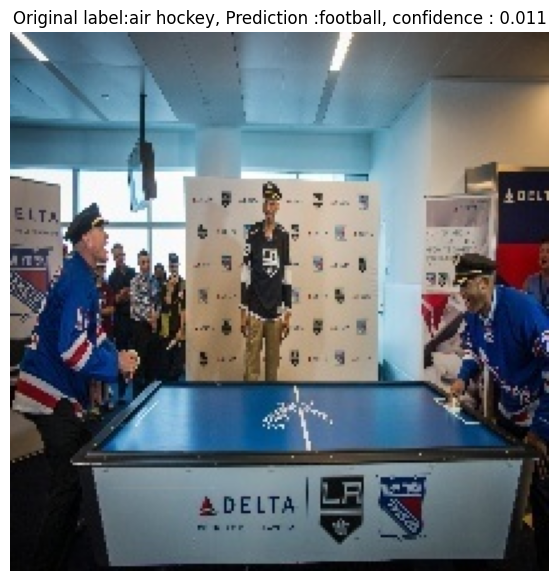

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    if i <= 5:
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

# ***Experiment 3: Trénujte posledních 8 vrstev pomocí rozšíření dat***

Tento experiment provádíme, abychom si ověřili, zda můžeme získat ještě lepší výsledky než předchozí experiment. Trénujeme více vrstev a také využíváme augmentaci dat při tréninku.

In [ ]:
#Load the VGG model
EfficientNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in EfficientNetB0_conv.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in EfficientNetB0_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB0_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7f2c4f1cb8e0> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2c4f1c9180> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7f2c4f1cbca0> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2c4f18b580> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f2c4f18bfa0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f2cda60bb20> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2c4e8f4160> False
<keras.src.layers.core.activation.Activation object at 0x7f2c4e8f55a0> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f2c4e8f5d20> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2c4e8f5a50> False
<keras.src.layers.core.activation.A

## ***Trénujte model***

Zde budeme pro rozšiřování dat používat imageDataGenerator.

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the Model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Found 12362 images belonging to 100 classes.
Found 2129 images belonging to 100 classes.
Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Save the Model
model.save('EfficientNetB0_sports_da_last8_layers.h5')

# You can also download it from the files tab on the left

In [ ]:
#from google.colab import files
files.download('EfficientNetB0_sports_da_last8_layers.h5')

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ***Ukažte chyby***

Found 223 images belonging to 6 classes.
11/11 [==============================] - 2s 177ms/step
No of errors = 9/223


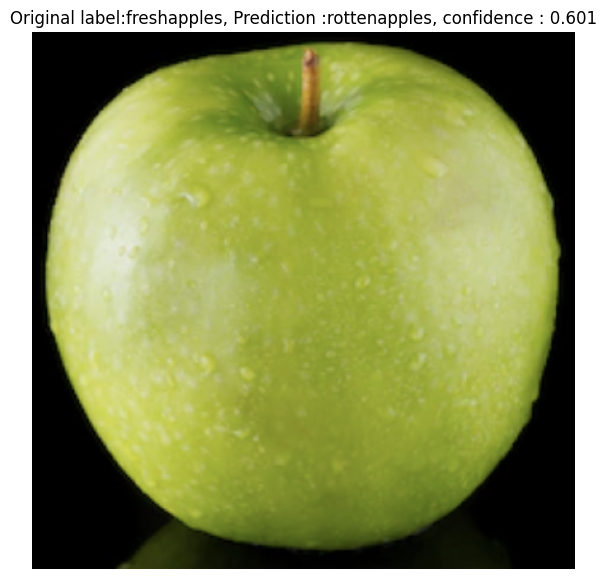

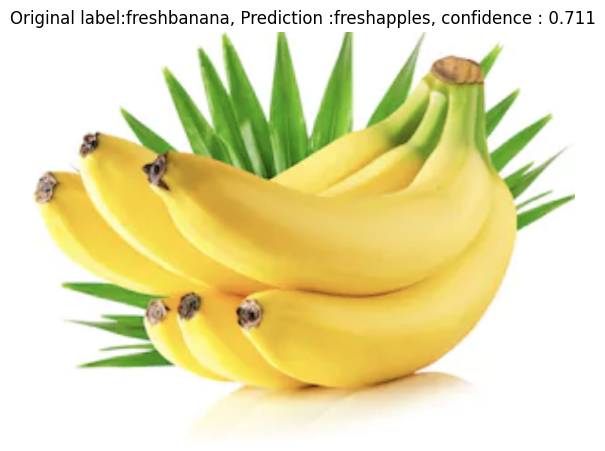

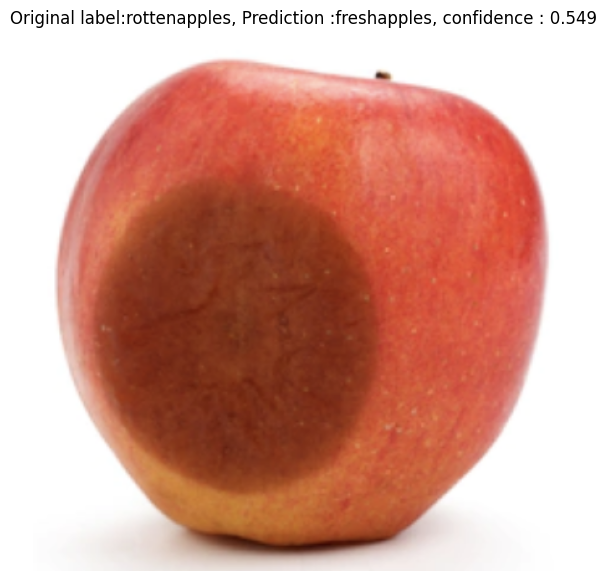

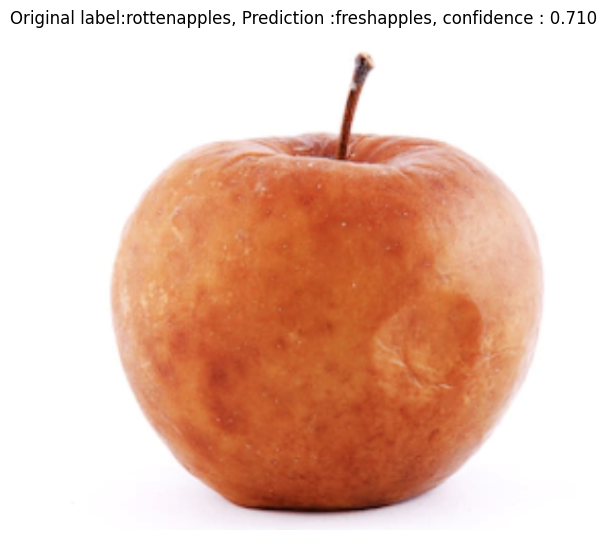

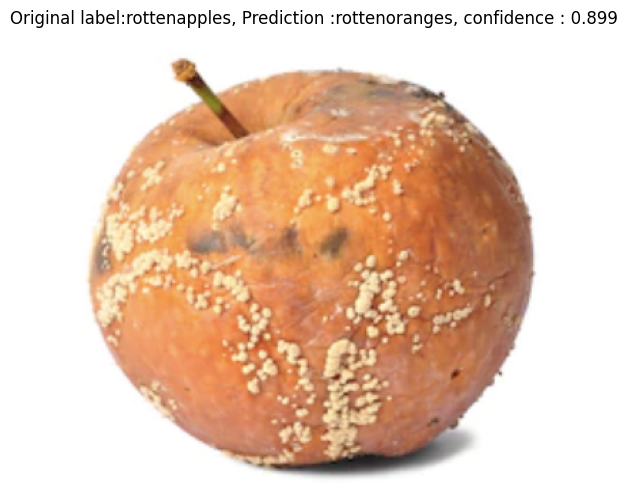

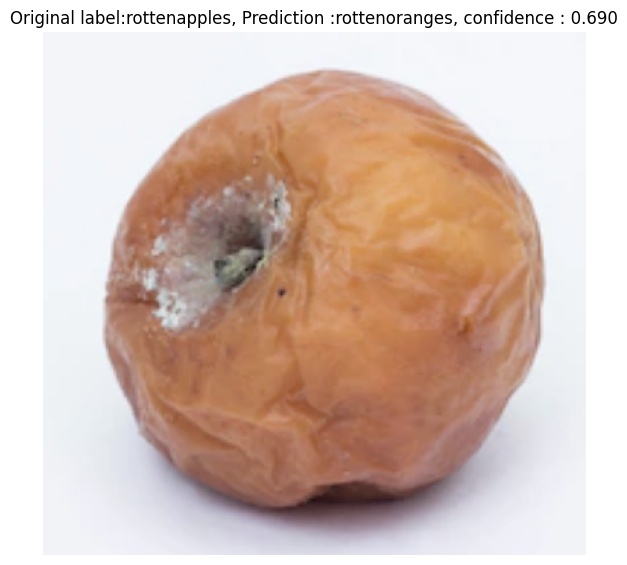

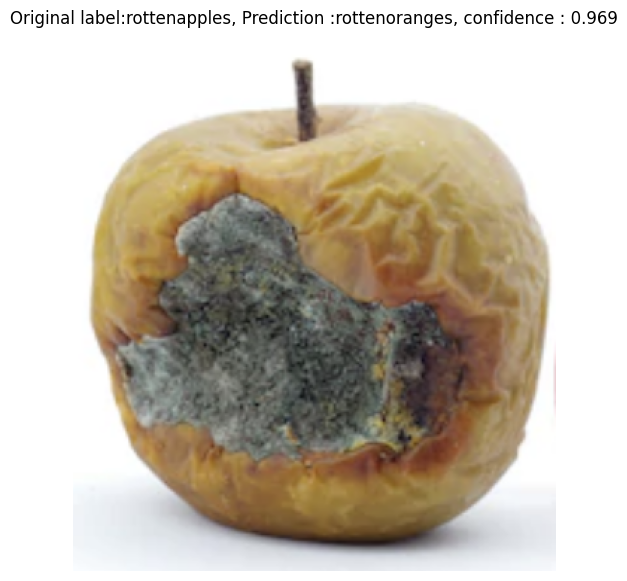

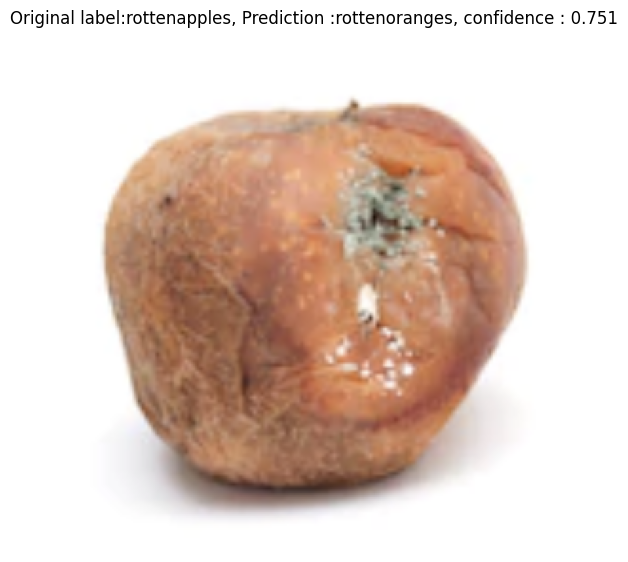

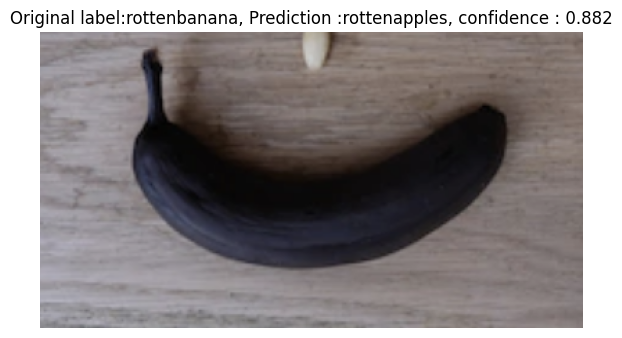

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

## ***Vyhodnocení***

V experimentu 2 se objevily známky nadměrného vybavení, které jsou do určité míry redukovány použitím augmentace dat. Měli byste zkusit spustit více epoch, abyste viděli účinek augmentace dat.

# ***Cvičení***

 - Zkuste použít jinou datovou sadu a zjistěte, zda stejný kód a síť funguje pro novou datovou sadu.
 - Zkuste rozmrazit více vrstev a uvidíte, jak se přesnost zlepší.
 - Zkuste jiný model místo VGG

# ***Reference a další materiály***

[Fine tuning](https://www.youtube.com/watch?v=WpzT9SDczfI)

[Apples Bananas Oranges](https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges)